In [1]:
import os
data_filename   = os.path.join(os.pardir, "data", "all_sz.json")
params_filename = os.path.join(os.pardir, "data", "default_params.json")

Load the subduction zone parameters

In [2]:
import json
with open(data_filename, "r") as fp:
    szparams = json.load(fp)

The "minimum" resolution, used to scale resolutions throughout the mesh.  The current default of 10.0km is way too high for a real subduction zone model but helps to keep this test notebook fast and readable.

In [3]:
minres = 10.0 # km

In [4]:
import numpy as np

Just for reference this is the code I used to generate the default parameters json file but it's turned off now and we just read it in in the next cell

Load the default parameters

In [5]:
with open(params_filename, "r") as fp:
    default_params = json.load(fp)

In [6]:
szname = "04_Cascadia"  # change this to switch subduction zones
szdata = szparams[szname]
coast_distance = szdata['deltaxcoast']
extra_width = szdata['deltaxwidth']
lc_depth = szdata['deltazmoho']
uc_depth = szdata['deltazuc']
io_depth = szdata['deltazoutflow']
points = np.asarray([szdata['trench']]+szdata['slabpoints'])
xs = points[:,0]
ys = points[:,1]
res = [1*minres if y > -200.0 else 3*minres for y in ys]

In [7]:
import sys, os
sys.path.append(os.path.join(os.path.pardir, 'python'))
import geometry as geo

Define the slab spline

In [8]:
slab = geo.SlabSpline(xs, ys, res=res, sid=default_params['slab_sid'], name="Slab")

Define the subduction geometry, including crustal layers and plot

Info    : Writing 'dataexample.geo_unrolled'...
Info    : Done writing 'dataexample.geo_unrolled'


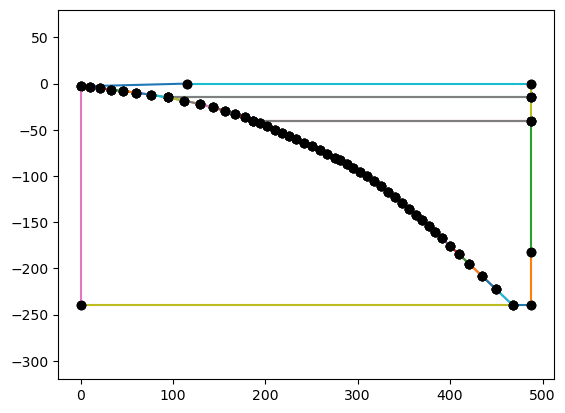

In [9]:
geom = geo.SubductionGeometry(slab, **default_params, 
                              wedge_top_res=default_params["wedge_top_res_fact"]*minres,
                              slab_base_res=default_params["slab_base_res_fact"]*minres,
                              coast_distance=coast_distance, extra_width=extra_width)
# adding the coupling depths may or may not be necessary
# depending on if they were included in the slab spline data already or not
# the geometry class should ignore them if they aren't necessary
slab.addpoint(80, "Slab::PartialCouplingDepth", res=1*minres)
slab.addpoint(82.5, "Slab::FullCouplingDepth", res=1*minres)
# add a lower crust
geom.addcrustlayer(lc_depth, "LowerCrust", 
                   sid=default_params["lc_base_sid"], rid=default_params["lc_rid"],
                   slab_res=default_params["lc_slab_res_fact"]*minres,
                   side_res=default_params["lc_side_res_fact"]*minres,
                   slab_sid=13, side_sid=5)
# oceanic subduction zones don't define an upper crust
if uc_depth is not None:
    geom.addcrustlayer(uc_depth, "UpperCrust", 
                       sid=default_params["uc_base_sid"], rid=default_params["uc_rid"],
                       slab_res=default_params["uc_slab_res_fact"]*minres,
                       side_res=default_params["uc_side_res_fact"]*minres,
                       slab_sid=13, side_sid=6)
# add the pre-defined in-out point
geom.addwedgesidepoint(io_depth, "WedgeSide::InOut", line_name="UpperWedgeSide", 
                       res=default_params["io_depth_res_fact"]*minres, 
                       sid=default_params["upper_wedge_side_sid"])
# add the slab detector point
geom.addslabpoint(default_params["slab_det_depth"], "Slab::DetectorPoint", res=1*minres)
geom.plot()
geom.writegeofile("dataexample.geo_unrolled")

In [10]:
mesh, ct, ft = geom.generatemesh()

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 10%] Meshing curve 4 (Line)
Info    : [ 10%] Meshing curve 5 (Line)
Info    : [ 10%] Meshing curve 6 (Line)
Info    : [ 20%] Meshing curve 7 (Line)
Info    : [ 20%] Meshing curve 8 (Line)
Info    : [ 20%] Meshing curve 9 (Line)
Info    : [ 20%] Meshing curve 10 (Line)
Info    : [ 20%] Meshing curve 11 (Line)
Info    : [ 20%] Meshing curve 12 (Line)
Info    : [ 30%] Meshing curve 13 (Line)
Info    : [ 30%] Meshing curve 14 (Line)
Info    : [ 30%] Meshing curve 15 (Line)
Info    : [ 30%] Meshing curve 16 (Line)
Info    : [ 30%] Meshing curve 17 (Line)
Info    : [ 30%] Meshing curve 18 (Line)
Info    : [ 40%] Meshing curve 19 (Line)
Info    : [ 40%] Meshing curve 20 (Line)
Info    : [ 40%] Meshing curve 21 (Line)
Info    : [ 40%] Meshing curve 22 (Line)
Info    : [ 40%] Meshing curve 23 (Line)
Info    : [ 40%] Meshing curve 24 (Line)
I


No module named 'trame'

Falling back to a static output.
  warnings.warn(



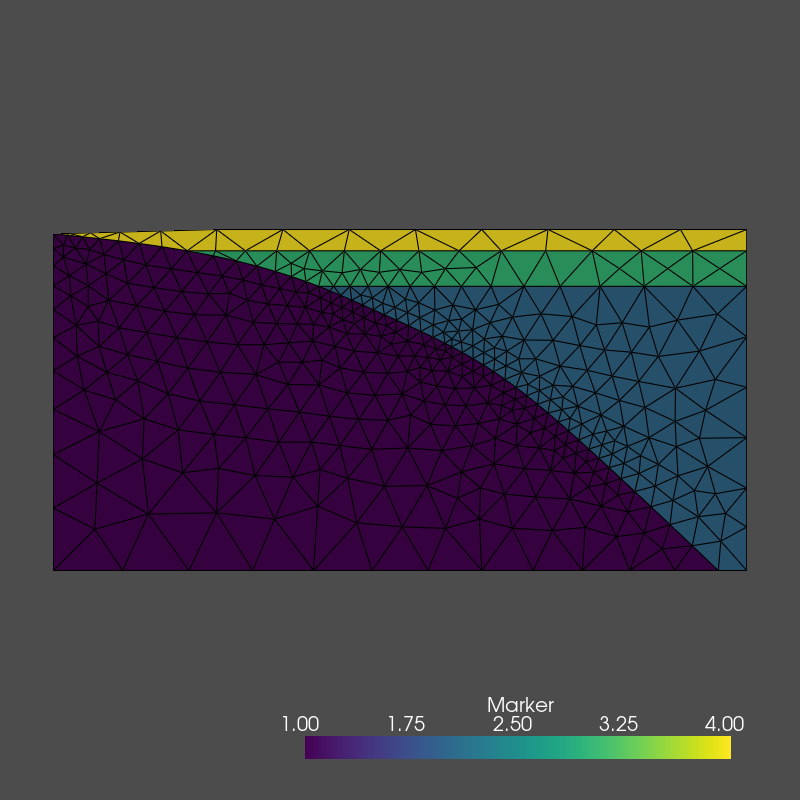

In [11]:
import pyvista
pyvista.start_xvfb()
from dolfinx.plot import create_vtk_mesh
topology, cell_types, x = create_vtk_mesh(mesh, mesh.topology.dim)
grid = pyvista.UnstructuredGrid(topology, cell_types, x)
num_local_cells = mesh.topology.index_map(mesh.topology.dim).size_local
grid.cell_data["Marker"] = ct.values[ct.indices<num_local_cells]
grid.set_active_scalars("Marker")

p = pyvista.Plotter(window_size=[800, 800])
p.add_mesh(grid, show_edges=True)
p.view_xy()
p.show()

In [12]:
import dolfinx
import numpy as np
import ufl
from dolfinx.fem import Function, FunctionSpace, dirichletbc, locate_dofs_geometrical, locate_dofs_topological, form

Ps2 = ufl.VectorElement("Lagrange", mesh.ufl_cell(), 2)
Ps1 = ufl.FiniteElement("Lagrange", mesh.ufl_cell(), 1)
Ve = FunctionSpace(mesh, Ps2)
Pe = FunctionSpace(mesh, Ps1)
THs = Ps2 * Ps1
Vs = FunctionSpace(mesh, THs)

(v_as, p_as) = ufl.TrialFunctions(Vs)
(v_ts, p_ts) = ufl.TestFunctions(Vs)

Vs0, _ = Vs.sub(0).collapse()
Vs00, _ = Vs0.sub(0).collapse()
Vs01, _ = Vs0.sub(1).collapse()
Vs1, _ = Vs.sub(1).collapse()

Pw2 = ufl.VectorElement("Lagrange", mesh.ufl_cell(), 2)
Pw1 = ufl.FiniteElement("Lagrange", mesh.ufl_cell(), 1)
Vwe = FunctionSpace(mesh, Pw2)
Pwe = FunctionSpace(mesh, Pw1)
THw = Pw2 * Pw1
Vw = FunctionSpace(mesh, THw)

(v_aw, p_aw) = ufl.TrialFunctions(Vw)
(v_tw, p_tw) = ufl.TestFunctions(Vw)

Vw0, _ = Vw.sub(0).collapse()
Vw00, _ = Vw0.sub(0).collapse()
Vw01, _ = Vw0.sub(1).collapse()
Vw1, _ = Vw.sub(1).collapse()


Vt = FunctionSpace(mesh, (ufl.FiniteElement("Lagrange", mesh.ufl_cell(), 2)))
T_a = ufl.TrialFunction(Vt)
T_t = ufl.TestFunction(Vt)



In [13]:
ft.find(1)

array([ 334,  337,  364,  426,  444,  489,  520,  562,  589,  626,  704,
        751,  754,  772,  811,  882,  883,  921,  953,  963,  997, 1035,
       1041, 1042, 1079, 1139, 1169, 1176, 1192, 1197, 1198, 1203, 1213],
      dtype=int32)

In [14]:
slab_surface_dofs_Vs0 = dolfinx.fem.locate_dofs_topological((Vs.sub(0), Vs0), 1, np.concatenate((ft.find(1), ft.find(13))))


In [15]:
slab_surface_dofs_Vs1 = dolfinx.fem.locate_dofs_topological((Vs.sub(1), Vs1), 1, np.concatenate((ft.find(1), ft.find(13))))


In [16]:
All_except_slab_dofs_Vs0 = dolfinx.fem.locate_dofs_topological((Vs.sub(0), Vs0), 2, np.concatenate((ct.find(2), ct.find(3), ct.find(4))))

In [17]:
NonSlab_dofs_Vs0_indices = [i for i, dof in enumerate(All_except_slab_dofs_Vs0[0]) if dof not in slab_surface_dofs_Vs0[0]]
NonSlab_dofs_Vs0 = [All_except_slab_dofs_Vs0[i][NonSlab_dofs_Vs0_indices] for i in range(len(All_except_slab_dofs_Vs0))]

In [18]:
All_except_slab_dofs_Vs1 = dolfinx.fem.locate_dofs_topological((Vs.sub(1), Vs1), 2, np.concatenate((ct.find(2), ct.find(3), ct.find(4))))

In [19]:
NonSlab_dofs_Vs1_indices = [i for i, dof in enumerate(All_except_slab_dofs_Vs1[0]) if dof not in slab_surface_dofs_Vs1[0]]
NonSlab_dofs_Vs1 = [All_except_slab_dofs_Vs1[i][NonSlab_dofs_Vs1_indices] for i in range(len(All_except_slab_dofs_Vs1))]

In [20]:
slab_surface_dofs_Vw0 = dolfinx.fem.locate_dofs_topological((Vw.sub(0), Vw0), 1, ft.find(1))

In [21]:
slab_surface_dofs_Vw1 = dolfinx.fem.locate_dofs_topological((Vw.sub(1), Vw1), 1, ft.find(1))

In [22]:
upperWedge_surface_dofs_Vw0 = dolfinx.fem.locate_dofs_topological((Vw.sub(0), Vw0), 1, ft.find(9))

In [23]:
upperWedge_surface_dofs_Vw1 = dolfinx.fem.locate_dofs_topological((Vw.sub(1), Vw1), 1, ft.find(9))

In [24]:
All_except_wedge_dofs_Vw0 = dolfinx.fem.locate_dofs_topological((Vw.sub(0), Vw0), 2, np.concatenate((ct.find(1), ct.find(3), ct.find(4))))

In [25]:
NonWedge_dofs_Vw0_indices = [i for i, dof in enumerate(All_except_wedge_dofs_Vw0[0]) if dof not in slab_surface_dofs_Vw0[0]]
NonWedge_dofs_Vw0 = [All_except_wedge_dofs_Vw0[i][NonWedge_dofs_Vw0_indices] for i in range(len(All_except_wedge_dofs_Vw0))]


In [26]:
All_except_wedge_dofs_Vw1 = dolfinx.fem.locate_dofs_topological((Vw.sub(1), Vw1), 2, np.concatenate((ct.find(1), ct.find(3), ct.find(4))))

In [27]:
NonWedge_dofs_Vw1_indices = [i for i, dof in enumerate(All_except_wedge_dofs_Vw1[0]) if dof not in slab_surface_dofs_Vw1[0]]
NonWedge_dofs_Vw1 = [All_except_wedge_dofs_Vw1[i][NonWedge_dofs_Vw1_indices] for i in range(len(All_except_wedge_dofs_Vw1))]


In [28]:
NonWedgeTop_dofs_Vw1_indices = [i for i, dof in enumerate(NonWedge_dofs_Vw1[0]) if dof not in upperWedge_surface_dofs_Vw1[0]]
NonWedgeTop_dofs_Vw1 = [NonWedge_dofs_Vw1[i][NonWedgeTop_dofs_Vw1_indices] for i in range(len(NonWedge_dofs_Vw1))]


In [29]:
Backarc_dofs_Vt = dolfinx.fem.locate_dofs_topological(Vt, 1, np.concatenate((ft.find(4), ft.find(5), ft.find(6))))

In [30]:
top_surface_dofs_Vt = dolfinx.fem.locate_dofs_topological(Vt, 1, np.concatenate((ft.find(12), ft.find(11))))

In [31]:
Trench_dofs_Vt = dolfinx.fem.locate_dofs_topological(Vt, 1, ft.find(2))

In [32]:
from petsc4py.PETSc import ScalarType
import scipy
k0=0.7515*10**-6
Ts = 0
Tm = 1350
kc = 0.8064516
erf = scipy.special.erf
h0=1000
H1=0.419354
H2=0.087097
z1=-15
z2=-szdata["deltazuc"]
km=1
Ao=szdata["tslab"]*(10**6)*365*24*60*60
zd = 2*((Ao*k0)**0.5)/h0
qs=szdata["qs"]
q1 = qs-(H1*z1)
q2=q1-H2*(z2-z1)
eta0=dolfinx.fem.Constant(mesh, ScalarType(10**21))
A_disl=28968
invA_disl=dolfinx.fem.Constant(mesh, ScalarType(1/A_disl))
E_o=dolfinx.fem.Constant(mesh, ScalarType(540000))
n=3.5
etamax=dolfinx.fem.Constant(mesh, ScalarType(10**25))
R=dolfinx.fem.Constant(mesh, ScalarType(8.3145))
T0=dolfinx.fem.Constant(mesh, ScalarType(1.0))
v0=dolfinx.fem.Constant(mesh, ScalarType(.023716014/365.25/24/60/60))
e0=dolfinx.fem.Constant(mesh, ScalarType(v0/h0))
nexp = (n-1.)/n
vo=szdata["vconv"]

In [33]:
Ttop = Function(Vt)
Ttop.x.set(0.0)
bc_Ttop = dirichletbc(Ttop, top_surface_dofs_Vt)

In [34]:
ytrench = szdata["trench"][1]
def T_trench(x):
    return Tm*erf((-x[1]+ytrench)/zd) 
Ttrench = Function(Vt)
Ttrench.interpolate(T_trench)
bc_trench_Vt = dirichletbc(Ttrench, Trench_dofs_Vt)

In [35]:

def T_backarc(values):
    Tbackarc = np.empty(values.shape[1])
    for i in range(values.shape[1]):
        x = values[:,i]    
        if  x[1] >= -z1:
            Tbackarc[i] = Ts-H1*(x[1]**2)/(2*kc) - (qs/kc)*x[1]
        elif x[1] >= -z2:
            T1 = (Ts-H1*(z1**2)/(2*kc) + (qs/kc)*z1)
            Tbackarc[i] = T1 - H2*((-x[1]-z1)**2)/(2*kc)+(-x[1]-z1)*q1/kc
        else:
            T2 = (Ts-H1*(z1**2)/(2*kc) + (qs/kc)*z1) - H2*((z2-z1)**2)/(2*kc)+(z2-z1)*q1/kc
            Tbackarc[i] = min(Tm, T2+(-x[1]-z2)*q2/km)
    
        # else:
        #     Tbackarc[i]=Tm

    return Tbackarc

TBackarc = Function(Vt)
TBackarc.interpolate(T_backarc)


bc_backarc_Vt = dirichletbc(TBackarc, Backarc_dofs_Vt)

In [36]:
zero_vs = Function(Vs0)
zero_vs.x.set(0.0)
bc_NonSlab_Vs0 = dirichletbc(zero_vs, NonSlab_dofs_Vs0, Vs.sub(0))


In [37]:
zero_ps = Function(Vs1)
zero_ps.x.set(0.0)
bc_NonSlab_Vs1 = dirichletbc(zero_ps, NonSlab_dofs_Vs1, Vs.sub(1))


In [38]:
zero_v = Function(Vw0)
zero_v.x.set(0.0)
bc_WedgeTop = dirichletbc(zero_v, upperWedge_surface_dofs_Vw0, Vw.sub(0))


In [39]:
zero_vw = Function(Vw0)
zero_vw.x.set(0.0)
bc_NonWedge_Vw0 = dirichletbc(zero_vw, NonWedge_dofs_Vw0, Vw.sub(0))


In [40]:
zero_pw = Function(Vw1)
zero_pw.x.set(0.0)
bc_NonWedgeTop_Vw1 = dirichletbc(zero_pw, NonWedgeTop_dofs_Vw1, Vw.sub(1))


In [41]:


def slab_velocity_s(values):
    return_values = np.empty((2,values.shape[1]))
    for i in range(values.shape[1]):
        x = values[:,i]
        return_values[:,i] = 0.1*slab.unittangentx(x[0])/vo
    return return_values
Vslab_s = Function(Vs0)
Vslab_s.interpolate(slab_velocity_s)
bc_slab_s = dirichletbc(Vslab_s, slab_surface_dofs_Vs0, Vs.sub(0))


In [42]:

def slab_velocity_w(values):
    return_values = np.empty((2,values.shape[1]))
    cd = 80.0
    vo = 0.023716
    for i in range(values.shape[1]):
        x = values[:,i]
        return_values[:,i] = min(max(-(x[1]+cd)/2.5, 0.0), 1.0)*0.1*slab.unittangentx(x[0])/vo
    return return_values
Vslab_w = Function(Vw0)
Vslab_w.interpolate(slab_velocity_w)
bc_slab_w = dirichletbc(Vslab_w, slab_surface_dofs_Vw0, Vw.sub(0))


In [43]:
T_i=Function(Vt)
T_i.interpolate(Ttrench, ct.find(1))
T_i.interpolate(TBackarc, np.concatenate((ct.find(2), ct.find(3), ct.find(4))))

In [44]:
ds = ufl.Measure('ds', domain=mesh, subdomain_data=ft)
dx = ufl.Measure("dx", domain=mesh, subdomain_data=ct)

In [45]:
from petsc4py.PETSc import ScalarType

zero_c = dolfinx.fem.Constant(mesh, ScalarType(0.0))
Ks0 = ufl.inner(ufl.sym(ufl.grad(v_ts)), 2*ufl.sym(ufl.grad(v_as)))*dx(1) + zero_c*ufl.inner(v_ts, v_as)*dx
Gs = -ufl.div(v_ts)*p_as*dx(1)
Ds = -p_ts*ufl.div(v_as)*dx(1)
Ss0 = Ks0 + Gs + Ds + zero_c*p_ts*p_as*dx


#Ss = ufl.inner(v_ts, v_as)*ufl.dx + p_ts*p_as*ufl.dx

fs = zero_c * (v_ts[0]+v_ts[1]+p_ts) * dx(1)
problem_vs0 = dolfinx.fem.petsc.LinearProblem(Ss0, fs, bcs=[bc_slab_s, bc_NonSlab_Vs1, bc_NonSlab_Vs0], petsc_options={"ksp_type": "preonly", "pc_type": "lu", "pc_factor_mat_solver_type" : "mumps"})
us_i = problem_vs0.solve()
vs_i=us_i.sub(0)

In [46]:
zero_c = dolfinx.fem.Constant(mesh, ScalarType(0.0))
Kw0 = ufl.inner(ufl.sym(ufl.grad(v_tw)), 2*ufl.sym(ufl.grad(v_aw)))*dx(2) + zero_c*ufl.inner(v_tw, v_aw)*dx
Gw = -ufl.div(v_tw)*p_aw*dx(2)
Dw = -p_tw*ufl.div(v_aw)*dx(2)
Sw0 = Kw0 + Gw + Dw + zero_c*p_tw*p_aw*dx

#Sw = ufl.inner(v_tw, v_aw)*dx + p_tw*p_aw*dx


fw = zero_c * (v_tw[0] + v_tw[1] + p_tw) * dx(2)
problem_vw0 = dolfinx.fem.petsc.LinearProblem(Sw0, fw, bcs=[bc_slab_w, bc_WedgeTop, bc_NonWedge_Vw0, bc_NonWedgeTop_Vw1], petsc_options={"ksp_type": "preonly", "pc_type": "lu", "pc_factor_mat_solver_type" : "mumps"})
uw_i = problem_vw0.solve()
vw_i=uw_i.sub(0)

In [47]:
from ufl import sym, inner, dot, grad, exp, sqrt

Tdim = Ts + T0*T_i
# wedge viscosity:
edot = sym(grad(vw_i))
eII = sqrt(0.5*inner(edot, edot))
# inverse dimensionless dislocation creep viscosity
inv_etadisl = eta0*invA_disl*exp(-E_o/(n*R*Tdim))*(e0**nexp)*(eII**nexp)
# inverse dimensionless effective viscosity
inv_etaprime = inv_etadisl + eta0/etamax
# "harmonic mean" viscosity (actually twice the harmonic mean)
etaprime = 1./inv_etaprime

# slab viscosity:
edots = sym(grad(vs_i))
eIIs = sqrt(0.5*inner(edots, edots))
# inverse dimensionless dislocation creep viscosity
inv_etadisls = eta0*A_disl*exp(-E_o/(n*R*Tdim))*(e0**nexp)*(eIIs**nexp)
# inverse dimensionless effective viscosity
inv_etaprimes = inv_etadisls + eta0/etamax
# "harmonic mean" viscosity (actually twice the harmonic mean)
etaprimes = 1./inv_etaprimes

In [48]:
from dolfinx import io
vs = us_i.sub(0).collapse()
#v = Vslab_s
vs.name = "Velocity"
ps = us_i.sub(1).collapse()
ps.name = "Pressure"

with io.VTKFile(mesh.comm, "output_v.pvd", "w") as vtk:
    vtk.write_function([vs], 0.0)
with io.VTKFile(mesh.comm, "output_p.pvd", "w") as vtk:
    vtk.write_function([ps], 0.0)


No module named 'trame'

Falling back to a static output.
  warnings.warn(



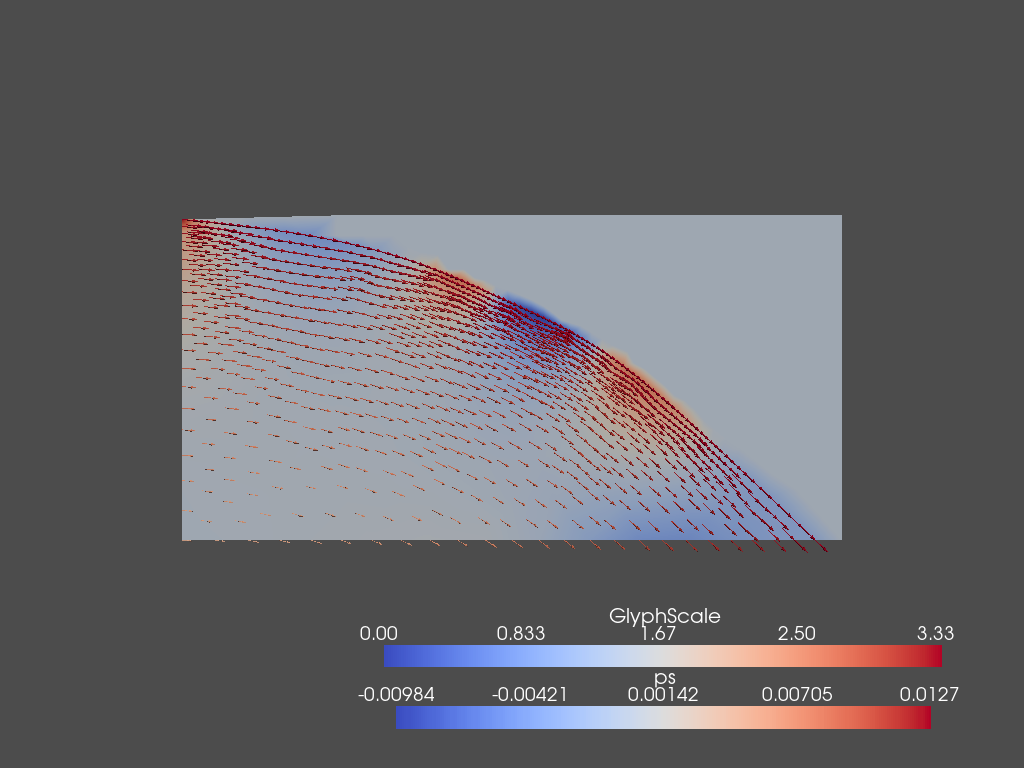

In [49]:
import pyvista
from dolfinx.plot import create_vtk_mesh
import matplotlib.pyplot as plt

pyvista.start_xvfb()
topologys, cell_types_s, geometrys = create_vtk_mesh(Vs0)
values_s = np.zeros((geometrys.shape[0], 3), dtype=np.float64)
values_s[:, :len(vs)] = vs.x.array.real.reshape((geometrys.shape[0], len(vs)))

# Create a point cloud of glyphs
function_grids = pyvista.UnstructuredGrid(topologys, cell_types_s, geometrys)
function_grids["vs"] = values_s
glyphs_s = function_grids.glyph(orient="vs", factor=4)

# create a scalar field on the P2 element
p_p2s = Function(Vs00)
# and interpolate the pressure onto it
p_p2s.interpolate(ps)
# then put that pressure onto the function_grid
function_grids["ps"] = p_p2s.x.array.real
function_grids.set_active_scalars("ps")

# Create plotter
plotter = pyvista.Plotter()
plotter.add_mesh(function_grids, show_edges=False, cmap='coolwarm')
plotter.add_mesh(glyphs_s, cmap='coolwarm')
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    plotter.savefig('Vel_Pressurefield2.pdf', format='pdf', dpi=600, bbox_inches='tight')

In [50]:
from dolfinx import io
vw = uw_i.sub(0).collapse()
#vw = Vslab_w
vw.name = "Velocityw"
pw = uw_i.sub(1).collapse()
pw.name = "Pressurew"

with io.VTKFile(mesh.comm, "output_vw.pvd", "w") as vtk:
    vtk.write_function([vw], 0.0)
with io.VTKFile(mesh.comm, "output_pw.pvd", "w") as vtk:
    vtk.write_function([pw], 0.0)


No module named 'trame'

Falling back to a static output.
  warnings.warn(



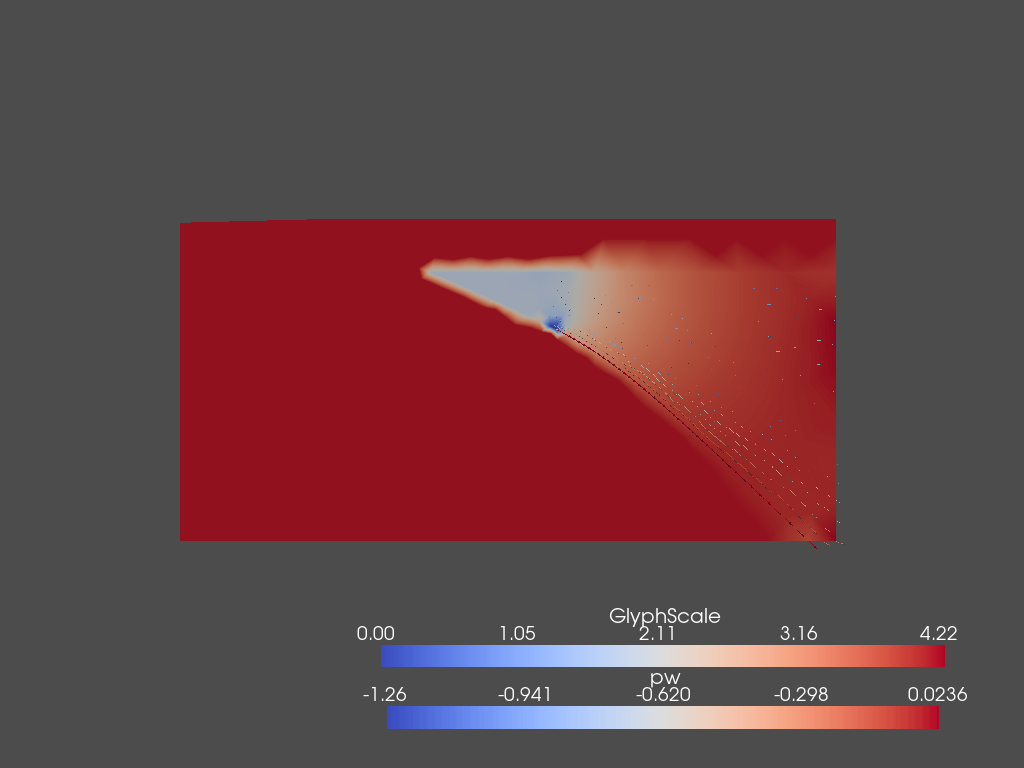

In [51]:
import pyvista
from dolfinx.plot import create_vtk_mesh
import matplotlib.pyplot as plt

pyvista.start_xvfb()
topologyw, cell_typesw, geometryw = create_vtk_mesh(Vw0)
valuesw = np.zeros((geometryw.shape[0], 3), dtype=np.float64)
valuesw[:, :len(vw)] = vw.x.array.real.reshape((geometryw.shape[0], len(vw)))

# Create a point cloud of glyphs
function_gridw = pyvista.UnstructuredGrid(topologyw, cell_typesw, geometryw)
function_gridw["vw"] = valuesw
glyphsw = function_gridw.glyph(orient="vw", factor=2)

# create a scalar field on the P2 element
p_p2w = Function(Vw00)
# and interpolate the pressure onto it
p_p2w.interpolate(pw)
# then put that pressure onto the function_grid
function_gridw["pw"] = p_p2w.x.array.real
function_gridw.set_active_scalars("pw")

# Create plotter
plotter = pyvista.Plotter()
plotter.add_mesh(function_gridw, show_edges=False, cmap='coolwarm')
plotter.add_mesh(glyphsw, cmap='coolwarm')
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    plotter.savefig('Vel_Pressurefield2.pdf', format='pdf', dpi=600, bbox_inches='tight')

In [52]:
S1 =  (T_t*dot(vs_i, grad(T_a))+inner(grad(T_a), grad(T_t)))*dx(1)
S2 =  (T_t*dot(vw_i, grad(T_a))+inner(grad(T_a), grad(T_t)))*dx(2)
S3 =  (inner(grad(T_a), grad(T_t)))*dx(3)
S4 =  (inner(grad(T_a), grad(T_t)))*dx(4)
St=S1+S2+S3+S4
ft = T_t*H1*dx(4) + T_t*H2*dx(3)

problem_T = dolfinx.fem.petsc.LinearProblem(St, ft, u=T_i, bcs=[bc_Ttop, bc_trench_Vt, bc_backarc_Vt], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
#T_i = problem_T.solve()

In [53]:
Ks = ufl.inner(ufl.sym(ufl.grad(v_ts)), 2*etaprimes*ufl.sym(ufl.grad(v_as)))*dx(1) + zero_c*ufl.inner(v_ts, v_as)*dx
Ss = Ks + Gs + Ds + zero_c*p_ts*p_as*dx
problem_vs = dolfinx.fem.petsc.LinearProblem(Ss, fs, u=us_i, bcs=[bc_slab_s, bc_NonSlab_Vs1, bc_NonSlab_Vs0], petsc_options={"ksp_type": "preonly", "pc_type": "lu", "pc_factor_mat_solver_type" : "mumps"})


In [54]:
Kw = ufl.inner(ufl.sym(ufl.grad(v_tw)), 2*etaprime*ufl.sym(ufl.grad(v_aw)))*dx(2) + zero_c*ufl.inner(v_tw, v_aw)*dx
Sw = Kw + Gw + Dw + zero_c*p_tw*p_aw*dx
fw = zero_c * (v_tw[0] + v_tw[1] + p_tw) * dx(2)
problem_vw = dolfinx.fem.petsc.LinearProblem(Sw, fw, u=uw_i, bcs=[bc_slab_w, bc_WedgeTop, bc_NonWedge_Vw0, bc_NonWedgeTop_Vw1], petsc_options={"ksp_type": "preonly", "pc_type": "lu", "pc_factor_mat_solver_type" : "mumps"})


In [55]:
from dolfinx import fem
rs = ufl.action(Ss, us_i)
rs_i = fem.assemble_vector(fem.form(rs))
fem.set_bc(rs_i.array, [bc_slab_s, bc_NonSlab_Vs1, bc_NonSlab_Vs0], scale=0.0)
rw = ufl.action(Sw, uw_i) 
rw_i = fem.assemble_vector(fem.form(rw))
fem.set_bc(rw_i.array, [bc_slab_w, bc_WedgeTop, bc_NonWedge_Vw0, bc_NonWedgeTop_Vw1], scale=0.0)

rT = ufl.action(St, T_i) - ft
rT_i = fem.assemble_vector(fem.form(rT))
fem.set_bc(rT_i.array, [bc_Ttop, bc_trench_Vt, bc_backarc_Vt], scale=0.0)

r = (rs_i.norm()**2 + rw_i.norm()**2 + rT_i.norm()**2)**0.5
r0 = r
r_rel = r/r0
r_tol = 1e-4
print(r, r_rel, r0)



9269.090788812146 1.0 9269.090788812146


In [56]:
rs_i.array

array([ 0., -0.,  0., ...,  0.,  0.,  0.])

In [57]:
max_its = 1
it = 0
while r_rel > r_tol:
    if it >= max_its: break
    T_i = problem_T.solve()
    us_i = problem_vs0.solve()
    uw_i = problem_vw0.solve()
    rs_i = fem.assemble_vector(fem.form(rs))
    fem.set_bc(rs_i.array, [bc_slab_s, bc_NonSlab_Vs1, bc_NonSlab_Vs0], scale=0.0)
    rw_i = fem.assemble_vector(fem.form(rw))
    fem.set_bc(rw_i.array, [bc_slab_w, bc_WedgeTop, bc_NonWedge_Vw0, bc_NonWedgeTop_Vw1], scale=0.0)
    
    rT_i = fem.assemble_vector(fem.form(rT))
    fem.set_bc(rT_i.array, [bc_Ttop, bc_trench_Vt, bc_backarc_Vt], scale=0.0)
    r = (rs_i.norm()**2 +rw_i.norm()**2 + rT_i.norm()**2)**0.5
    r_rel = r/r0
    print (r_rel, r0)
    it += 1

2.180309612328046 9269.090788812146


In [58]:
rs_i.array

array([ 0., -0.,  0., ...,  0.,  0.,  0.])


No module named 'trame'

Falling back to a static output.
  warnings.warn(



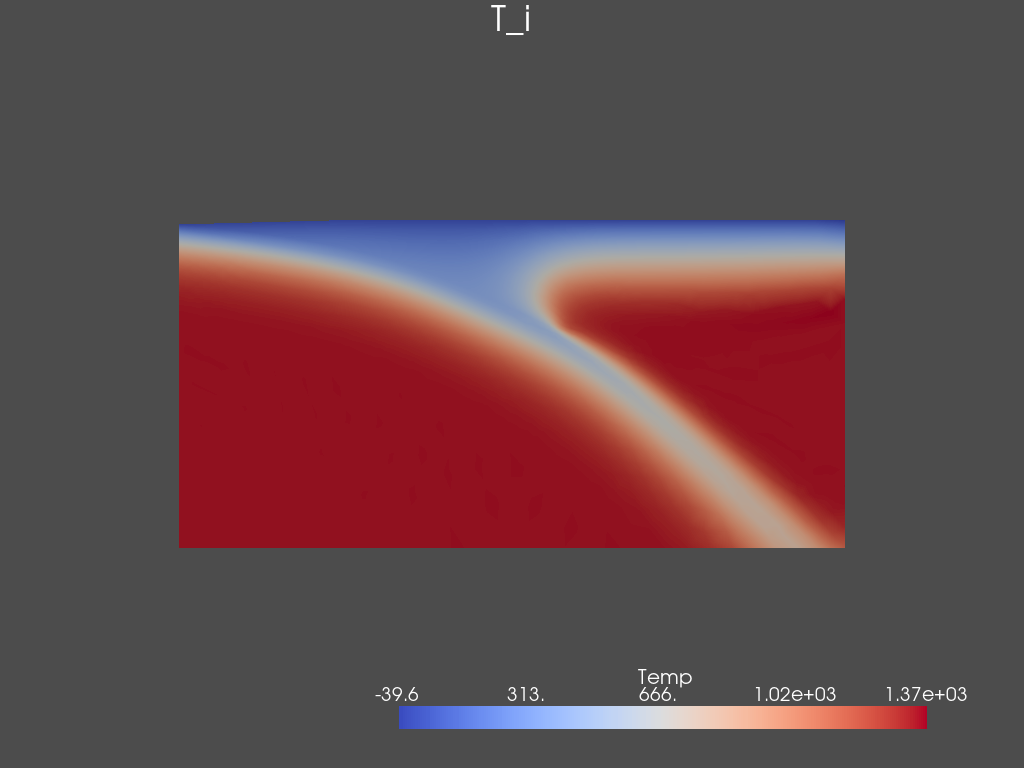

In [59]:
pyvista.start_xvfb()

from dolfinx.plot import create_vtk_mesh
pyvista_cells, cell_types, geometry = create_vtk_mesh(T_i.function_space)
grid = pyvista.UnstructuredGrid(pyvista_cells, cell_types, geometry)
grid.point_data["Temp"] = T_i.x.array
grid.set_active_scalars("Temp")

plotter = pyvista.Plotter()
plotter.add_text("T_i", position="upper_edge", font_size=14)
plotter.add_mesh(grid, show_edges=False, cmap = 'coolwarm')
plotter.view_xy()

if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    figure = plotter.screenshot("Temp.pdf")

In [60]:
with io.VTKFile(mesh.comm, "output_T.pvd", "w") as vtk:
    vtk.write_function([T_i], 0.0)

In [61]:

vs_i.x.array

array([ 3.31447501, -0.35407138,  0.        , ...,  0.        ,
        0.        ,  0.        ])

In [62]:
vw_i.x.array

array([ 0.        ,  0.        ,  0.        , ...,  0.02356369,
        2.94085369, -1.75371385])


No module named 'trame'

Falling back to a static output.
  warnings.warn(



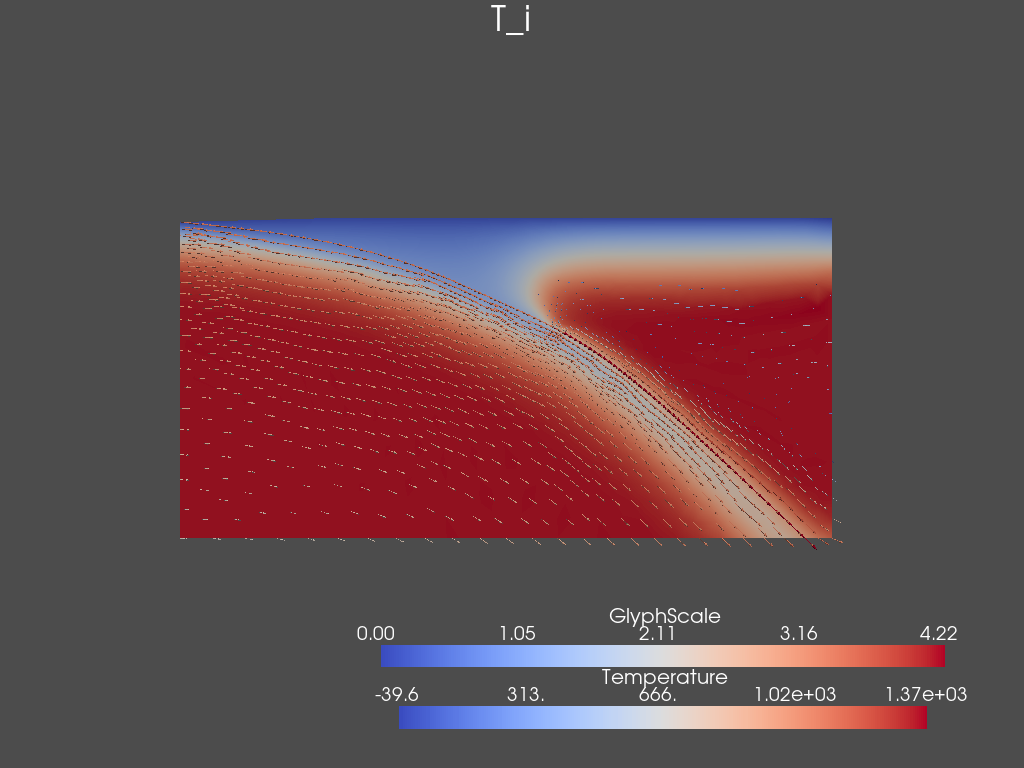

In [63]:
import pyvista
from dolfinx.plot import create_vtk_mesh

pyvista.start_xvfb()
topology_s, cell_types_s, geometry_s = create_vtk_mesh(Vs0)
values_s = np.zeros((geometry_s.shape[0], 3), dtype=np.float32)
values_s[:, :len(vs_i)] = vs_i.collapse().x.array.real.reshape((geometry_s.shape[0], len(vs_i)))

function_grid_s = pyvista.UnstructuredGrid(topology_s, cell_types_s, geometry_s)
function_grid_s["vs_i"] = values_s
glyphs_s = function_grid_s.glyph(orient="vs_i", factor=3.0)

pyvista.start_xvfb()
topology_w, cell_types_w, geometry_w = create_vtk_mesh(Vw0)
values_w = np.zeros((geometry_w.shape[0], 3), dtype=np.float32)
values_w[:, :len(vw_i)] = vw_i.collapse().x.array.real.reshape((geometry_w.shape[0], len(vw_i)))

function_grid_w = pyvista.UnstructuredGrid(topology_w, cell_types_w, geometry_w)
function_grid_w["vw_i"] = values_w
glyphs_w = function_grid_w.glyph(orient="vw_i", factor=3.0)

glyphs = glyphs_s+glyphs_w

pyvista_cells, cell_types, geometry = create_vtk_mesh(Vt)
grid = pyvista.UnstructuredGrid(pyvista_cells, cell_types, geometry)
grid.point_data["Temperature"] = T_i.x.array
grid.set_active_scalars("Temperature")
plotter = pyvista.Plotter()
plotter.add_text("T_i", position="upper_edge", font_size=14)
plotter.add_mesh(grid, show_edges=False, cmap = 'coolwarm')

plotter.add_mesh(glyphs, cmap='coolwarm')
plotter.view_xy()
if not pyvista.OFF_SCREEN:
     plotter.show()
else:
    glyphs = plotter.screenshot('glyphs.pdf', format='pdf')